In [2]:
# Configuration
var_mtcnn_image_size = 160
var_mtcnn_margin = 0
var_dataset_folder = 'lfw'
var_dataset_cropped_folder = 'lfw_cropped/'
var_temp_folder = './temp'
var_val_split = 0.2
var_test_split = 0.1
var_batch_size = 8


# Create folders if they dont exist
import os 
if not os.path.exists(var_dataset_folder):
    os.makedirs(var_dataset_folder)
if not os.path.exists(var_temp_folder):
    os.makedirs(var_temp_folder)
if not os.path.exists(var_dataset_cropped_folder):
    os.makedirs(var_dataset_cropped_folder)
    

## Download Dataset - LFW Example 

In [3]:
LFW_DATA_URL = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
var_dataset_folder = 'dataset'

import requests
import tarfile
from PIL import Image
from os.path import exists, join

# Download Dataset
target_filepath = join(var_dataset_folder, "lfw.tgz")
r = requests.get(LFW_DATA_URL, allow_redirects=True)
open(target_filepath,'wb').write(r.content)

# Extract images
tar = tarfile.open(target_filepath, "r:gz")
tar.extractall(path=var_dataset_folder)
tar.close()

Take care for the next step: if you extract the lwf folder a new sub-folder lfw gets created. Make sure to change var_dataset_folder accordingly or move the files.

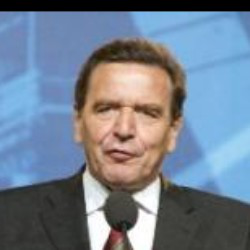

In [4]:
import glob
import numpy as np
from os.path import exists, join

# Show random image to test
image_filenames = glob.glob(join(var_dataset_folder, "**/*.jpg"), recursive=True)
n = np.random.randint(0, len(image_filenames))
Image.open(image_filenames[n])



## Dataset Cropping with MTCNN


In [8]:
from facenet_pytorch import MTCNN
from PIL import Image

class FaceDetection:  
    def __init__(self, image_size, margin): 
        self.mtcnn_model = MTCNN(image_size=image_size,margin=margin) 
    
    def pass_face(self, img): 
        return self.mtcnn_model(img) 
    
    def save_face(self, img, path): 
        return self.mtcnn_model(img, save_path=path) 
    
mtcnn_model = FaceDetection(image_size = var_mtcnn_image_size, margin = var_mtcnn_margin)

In [ ]:
# make sure to execute above cell before!
# progress bar will count persons and not images itself, so dont get confused with the count
import os
from tqdm import tqdm
from PIL import Image

errors = 0
loop = tqdm(list(os.walk(var_dataset_folder)), leave=False)  
for subdir, dirs, files in loop:
    for file in files:
        path = os.path.join(subdir, file)
        new_path = path.replace(var_dataset_folder, var_dataset_cropped_folder)
        img = Image.open(path) 
        loop.set_description("Processing %s" % file)
        try:
            mtcnn_model.save_face(img, new_path)
        except: 
            errors += 1
            loop.set_postfix({"errors": errors })
                

Processing 001.jpg:  21%|██        | 2219/10576 [1:18:15<2:56:08,  1.26s/it, errors=713] 

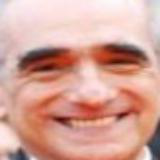

In [3]:
import glob
import numpy as np
from os.path import exists, join

# Show random image to test
image_filenames = glob.glob(join(var_dataset_cropped_folder, "**/*.jpg"), recursive=True)
n = np.random.randint(0, len(image_filenames))
Image.open(image_filenames[n])

## Dataset Augmentation

We will apply augmentation to the copped dataset here

In [ ]:

import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import os
from os.path import exists, join
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import functional as F


class DatasetAugmentation():
    def __init__(self, folder, multiplicator):
        self.folder = folder
        self.multiplicator = multiplicator

    def augment(self):
        errors = 0
        loop = tqdm(list(os.walk(self.folder)), leave=False)
        for subdir, dirs, files in loop:
            for file in files:
                if file.find("augmented") != -1:
                    errors += 1
                    loop.set_postfix({"excluded files": errors })
                else:
                    self.augment_file(path=subdir,filename=file)

    def augment_file(self, path, filename):
        self.save_augment_file_f(
            path=path,
            filename=filename,
            augmentation_name='hflip',
            transforms_f=F.hflip
        )
        self.save_augment_file_f(
            path=path,
            filename=filename,
            augmentation_name='bright',
            transforms_f=self.bright
        )
        self.save_augment_file_f(
            path=path,
            filename=filename,
            augmentation_name='dark',
            transforms_f=self.dark
        )

        in_path = '../../{}/{}'.format(path, filename)
        out_path = '../../{}/augmented_{}_{}'.format(path, 'mask', filename)
        run = f"python util/MaskTheFace/mask_the_face_custom.py\
                    --path '{in_path}'\
                    --out_path '{out_path}'\
                    --mask_type 'N95'"
        !{run}

    def bright(self, img):
        return F.adjust_brightness(img=img,brightness_factor=2)
    def dark(self, img):
        return F.adjust_brightness(img=img,brightness_factor=0.5)

    def save_augment_file_f(self, path, filename, augmentation_name, transforms_f):
        out_path = '{}/augmented_{}_{}'.format(path, augmentation_name, filename)
        in_path = '{}/{}'.format(path, filename)
        image = Image.open(in_path)
        image = transforms_f(image)
        image.save(out_path)
        #print("tranformed "+out_path)

    def save_augment_file(self, path, filename, augmentation_name, transforms_var):
        out_path = '{}/augmented_{}_{}'.format(path, augmentation_name, filename)
        in_path = '{}/{}'.format(path, filename)
        image = Image.open(in_path)
        image = F.vflip(image)
        image.save(out_path)
        transform = transforms.Compose(
            transforms_var,
        )
        print("tranformed"+out_path)
        transform(image).save(out_path)

In [ ]:
aug =  DatasetAugmentation(folder=var_dataset_cropped_folder, multiplicator=False)
aug.augment()

In [ ]:
celeb = "Colleen_Ryan"
image = "Colleen_Ryan_0001.jpg"
path = var_dataset_cropped_folder

In [ ]:
Image.open(var_dataset_cropped_folder+"/"+celeb+"/"+image)

In [ ]:
Image.open(var_dataset_cropped_folder+"/"+celeb+"/augmented_mask_"+image)

In [ ]:
Image.open("dataset/lfw/"+celeb+"/augmented_dark_"+image)

In [ ]:
Image.open("dataset/lfw/"+celeb+"/augmented_hflip_"+image)

In [7]:
augmentor = DatasetAugmentation(folder=var_dataset_cropped_folder,multiplicator=False)
augmentor.augment()


100%|█████████▉| 5748/5750 [09:04<00:00, 22.39it/s, excluded files=162]
                                                                       

## Mean + Std. Dev Calculation

In [2]:
run = f"python util/calculate_rgb_mean_std.py\
                    --dir {var_dataset_cropped_folder}"
!{run}

100%|█████████████████████████████████████████████| 4/4 [01:18<00:00, 19.51s/it]
Mean: tensor([0.6158, 0.4637, 0.3757]), Std: tensor([0.2124, 0.1863, 0.1812])


In [7]:
mean = [0.6158, 0.4637, 0.3757]
std = [0.2124, 0.1863, 0.1812]

## Dataset Loading

This is just a sample implemtation of a Dataset-Loader. Depending on the used Loss, it is using an own Loader.

In [51]:
# Define Dataset
import numpy as np

from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import os
from os.path import exists, join
from PIL import Image

class Dataset(Dataset):
    """ faceguard Image dataset."""
    
    def __init__(self, dataset_folder, mean, std):
        self.faces = []
        self.labels = []
        self.mean = mean
        self.std = std
        self.dataset_folder = dataset_folder
        self.read_file_paths()
        
    
    def read_file_paths(self):
        for subdir in os.listdir(self.dataset_folder):
            path = join(self.dataset_folder, subdir)
            for filename in os.listdir(path):
                image_path = '{}/{}'.format(path, filename) 
                self.faces.append(image_path)
                self.labels.append(subdir)   
                
    def __len__(self):
        return len(self.faces)
    
    def __getitem__(self, idx):
        image = Image.open(self.faces[idx])
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize(self.mean, self.std)]
        )
        image = transform(image)
            
            
        label = self.labels[idx]    
        return  image, label

In [52]:
dataset = Dataset(dataset_folder=var_dataset_cropped_folder,mean=mean,std=std)

In [53]:
import torch

# Define Dataset Split and Loader

class DatasetLoader():
    def __init__(self, dataset, temp_folder):
        self.dataset = dataset
        self.temp_folder = var_temp_folder
        
    def do_split(self, val_ratio, test_ratio):
        training_ratio = 1 - val_ratio - test_ratio
        n_samples = len(dataset)

        shuffled_indices = np.random.permutation(n_samples)
        self.testset_inds = shuffled_indices[:int(n_samples * test_ratio)]
        self.validationset_inds = shuffled_indices[int(n_samples * test_ratio) : int(n_samples * test_ratio) + int(n_samples * val_ratio)]
        self.trainingset_inds = shuffled_indices[int(n_samples * test_ratio) + int(n_samples * val_ratio) :]
        
        status = (f"Got dataset with {n_samples} items\n"
            f"Splitted for Train ({len(self.trainingset_inds)}) - {len(self.trainingset_inds)/n_samples}  \n"
            f"Splitted for Val ({len(self.validationset_inds)}) - {len(self.validationset_inds)/n_samples}  \n"
            f"Splitted for Test ({len(self.testset_inds)}) - {len(self.testset_inds)/n_samples}")
        print (status)
        
        np.save(join(self.temp_folder, "train_idx.npy"), self.trainingset_inds)
        np.save(join(self.temp_folder, "val_idx.npy"), self.validationset_inds)
        np.save(join(self.temp_folder, "test_idx.npy"), self.testset_inds)
        
        return self.trainingset_inds,self.validationset_inds,self.testset_inds

    
    def load_split(self):
        self.validationset_inds = np.load(join(self.temp_folder, "val_idx.npy"))
        self.trainingset_inds = np.load(join(self.temp_folder, "train_idx.npy"))
        self.testset_inds = np.load(join(self.temp_folder, "test_idx.npy"))
        
        return self.trainingset_inds,self.validationset_inds,self.testset_inds
    
    def get_loader(self, batch_size): 
        train_dataset = torch.utils.data.Subset(self.dataset, indices=self.trainingset_inds)
        val_dataset = torch.utils.data.Subset(self.dataset, indices=self.validationset_inds)
        test_dataset = torch.utils.data.Subset(self.dataset, indices=self.testset_inds)

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=batch_size,
                                                   num_workers=0,
                                                   shuffle=True, sampler=None,
                                                   collate_fn=None)

        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                   batch_size=batch_size,
                                                   num_workers=0,
                                                   shuffle=False, sampler=None,
                                                   collate_fn=None)

        val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                   batch_size=batch_size,
                                                   num_workers=0,
                                                   shuffle=False, sampler=None,
                                                   collate_fn=None)
        
        return train_loader, test_loader, val_loader

In [54]:
loader = DatasetLoader(dataset=dataset, temp_folder=var_temp_folder)
loader.do_split(val_ratio=var_val_split,test_ratio=var_test_split)
train_loader, test_loader, val_loader = loader.get_loader(var_batch_size)


Got dataset with 13233 items
Splitted for Train (9264) - 0.70006801178871  
Splitted for Val (2646) - 0.19995465880752664  
Splitted for Test (1323) - 0.09997732940376332
